### CNN for CIFAR10

CNN model that can be used for classification tasks. 

In this demo, we will train a 3-layer CNN on the CIFAR10 dataset. 

Let us first import the required modules.

In [51]:
import torch
import torchvision
import wandb
import math
from torch import nn
from einops import rearrange
from argparse import ArgumentParser
from pytorch_lightning import LightningModule, Trainer, Callback
from pytorch_lightning.loggers import WandbLogger
from torchmetrics.functional import accuracy
from torch.optim import SGD, Adam
from torch.optim.lr_scheduler import CosineAnnealingLR

#### CNN using PyTorch `nn.Conv2D`

In this example, we use `nn.Conv2D` to create a 3-layer CNN model. Note the following:
1. The first layer number of input features is equal to the number of input RGB channels (3).
2. The output of the first layer is equal to the number of input features of the second layer.
3. The same matching for the second and third (last) layer.
4. We use `nn.MaxPool2d` to reduce the output feature map size.
5. At the same, we increase the number of feature maps after every layer.
6. We use `nn.ReLU` to activate the output of the layer.
7. For the last linear layer `nn.Linear`, the number of input features has to be supplied manually. Below in comment is a simple script that can be used to calculate the number of input features.

Ideas for experimentation:
1. Try other kernel sizes
2. Try deeper models
3. Try different activation functions
4. Try applying skip connections


Original Image shape: (224, 224, 3)


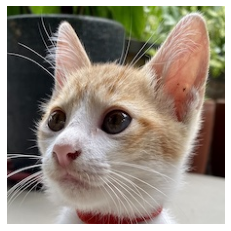

In [52]:
from einops import rearrange, repeat, reduce
from matplotlib import image
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

img = image.imread("wonder_cat.jpg")
print("Original Image shape:", img.shape)

plt.imshow(img)
plt.axis('off')
plt.show()

#img = repeat(img, "h w c-> h (w 3) c")

#plt.imshow(img)
#plt.axis('off')
#plt.show()

Original Image shape: (224, 224, 3)
Image shape: (224, 224, 3)
Z shape: (222, 222, 3)


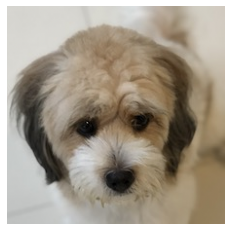

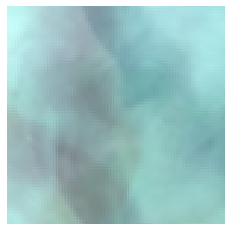

In [53]:
#img = image.imread("wonder_cat.jpg") / 255.0
img = image.imread("aki_dog.jpg") / 255.0
print("Original Image shape:", img.shape)

# split the image into p1 x p2 patches. 
k = 3
n_filters = 3
kernel = np.random.random((n_filters, 3, k, k))
kernel = rearrange(kernel, 'b c h w -> (c h w) b')

img = img[::,::,:]
#y = []
wk = k * (img.shape[0] // k) 
hk = k * (img.shape[1] // k)
wf = img.shape[0] % k 
hf = img.shape[1] % k
print("Image shape:", img.shape)
z = np.empty((img.shape[0]-k+1, img.shape[1]-k+1, img.shape[2]))
print("Z shape:", z.shape)


for i in range(k):
    hoff = i if hf >= i else (-k + i)
    for j in range(k):
        woff = j if wf >= j else (-k + j)
        x = img[i: hk + hoff:, j: wk + woff:, :]
        
        h = x.shape[0] // k
        w = x.shape[1] // k
        
        x = rearrange(x, "(p1 h) (p2 w) c -> (h w) (p1 p2 c)", p1=k, p2=k)
        x = x @ kernel

        # for testing ala minpool
        # x = rearrange(x, "(p1 h) (p2 w) c -> (h w) p1 p2 c", p1=k, p2=k)
        #x = reduce(x, "b h w c -> b c", 'min')

        x = rearrange(x, '(h w) c -> h w c', h=h, w=w)

        z[i::k,j::k,:] = x
    
plt.imshow(img)
plt.axis('off')
plt.show()

z = z / np.max(z)
plt.imshow(z)
plt.axis('off')
plt.show()

In [89]:
class TensorConv2d(nn.Module):
    def __init__(self, n_features, n_filters, kernel_size):
        super().__init__()
        self.n_features = n_features
        self.kernel_size = kernel_size
        self.n_filters = n_filters
        self.kernel = torch.zeros((n_features * kernel_size * kernel_size, n_filters), requires_grad=True)
        self.bias = torch.zeros(n_filters, requires_grad=True)
        self.reset_parameters()

    def reset_parameters(self):
        nn.init.constant_(self.bias, 0)
        #nn.init.kaiming_uniform_(self.kernel, a=math.sqrt(5))
        nn.init.xavier_uniform(self.kernel)
        
    def forward(self, x):
        #x = rearrange(x, 'b c h w -> b h w c')
        k = self.kernel_size
        b = x.shape[0]
        h = x.shape[2]
        w = x.shape[3]
        #c = x.shape[3]
        
        wk = k * (w // k) 
        hk = k * (h // k)
        wf = w % k 
        hf = h % k
        #z = torch.empty((b, h-k+1, w-k+1, self.n_filters))
        z = torch.empty((b, self.n_filters, h-k+1, w-k+1 ))
        for i in range(k):
            hoff = i if hf >= i else (-k + i)
            for j in range(k):
                woff = j if wf >= j else (-k + j)
                
                #y = x[:, i: hk + hoff:, j: wk + woff:, :]
                y = x[:, :, i: hk + hoff:, j: wk + woff:]
        
                nh = y.shape[2] // k
                nw = y.shape[3] // k
        
                #y = rearrange(y, "b (p1 h) (p2 w) c -> b (h w) (p1 p2 c)", p1=k, p2=k)
                y = rearrange(y, "b c (p1 h) (p2 w) -> b (h w) (p1 p2 c)", p1=k, p2=k)

                y = y @ self.kernel + self.bias

                #y = rearrange(y, 'b (h w) c -> b h w c', h=nh, w=nw)
                y = rearrange(y, 'b (h w) c -> b c h w', h=nh, w=nw)

                #z[:,i::k,j::k,:] = y
                z[:,:,i::k,j::k] = y
        
        #z = rearrange(z, 'b h w c -> b c h w')
        return z

In [90]:
class SimpleCNN(nn.Module):
    def __init__(self, n_features=3, kernel_size=3, n_filters=32, num_classes=10, conv2d=nn.Conv2d):
        super().__init__()
        self.conv1 = conv2d(n_features, n_filters, kernel_size=kernel_size)
        self.conv2 = conv2d(n_filters, n_filters*2, kernel_size=kernel_size)
        self.conv3 = conv2d(n_filters*2, n_filters*4, kernel_size=kernel_size)
        
        self.fc1 = nn.Linear(2048, num_classes)

    def forward(self, x):
        y = nn.ReLU()(self.conv1(x))
        y = nn.MaxPool2d(kernel_size=2)(y)
        y = nn.ReLU()(self.conv2(y))
        y = nn.MaxPool2d(kernel_size=2)(y)
        y = nn.ReLU()(self.conv3(y))
        y = rearrange(y, 'b c h w -> b (c h w)')

        y = self.fc1(y)
        return y
        # we dont need to compute softmax since it is already
        # built into the CE loss function in PyTorch
        #return F.log_softmax(y, dim=1)


# use this to get the correct input shape for  fc1. In this case,
# comment out y=self.fc1(y) and run the code below.
#model = SimpleCNN()
#data = torch.Tensor(1, 3, 32, 32)
#y = model(data)
#print("Y.shape:", y.shape)

#### PyTorch Lightning Module for CNN

This is the PL module so we can easily change the implementation of the CNN and compare the results.  More detailed results can be found on the `wandb.ai` page.

Using `model` parameter, we can easily switch between different model implementations. We also benchmark the result using a ResNet18 model. 

In [91]:
class LitCIFAR10Model(LightningModule):
    def __init__(self, num_classes=10, lr=0.001, batch_size=64,
                 num_workers=4, max_epochs=30,
                 model=SimpleCNN, conv2d=nn.Conv2d):
        super().__init__()
        self.save_hyperparameters()
        self.model = model(num_classes=num_classes, conv2d=conv2d)
        self.loss = nn.CrossEntropyLoss()

    def forward(self, x):
        return self.model(x)

    # this is called during fit()
    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.forward(x)
        loss = self.loss(y_hat, y)
        return {"loss": loss}

    # calls to self.log() are recorded in wandb
    def training_epoch_end(self, outputs):
        avg_loss = torch.stack([x["loss"] for x in outputs]).mean()
        self.log("train_loss", avg_loss, on_epoch=True)

    # this is called at the end of an epoch
    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.forward(x)
        loss = self.loss(y_hat, y)
        acc = accuracy(y_hat, y) * 100.
        # we use y_hat to display predictions during callback
        return {"y_hat": y_hat, "test_loss": loss, "test_acc": acc}

    # this is called at the end of all epochs
    def test_epoch_end(self, outputs):
        avg_loss = torch.stack([x["test_loss"] for x in outputs]).mean()
        avg_acc = torch.stack([x["test_acc"] for x in outputs]).mean()
        self.log("test_loss", avg_loss, on_epoch=True, prog_bar=True)
        self.log("test_acc", avg_acc, on_epoch=True, prog_bar=True)

    # validation is the same as test
    def validation_step(self, batch, batch_idx):
       return self.test_step(batch, batch_idx)

    def validation_epoch_end(self, outputs):
        return self.test_epoch_end(outputs)

    # we use Adam optimizer
    def configure_optimizers(self):
        optimizer = Adam(self.parameters(), lr=self.hparams.lr)
        # this decays the learning rate to 0 after max_epochs using cosine annealing
        scheduler = CosineAnnealingLR(optimizer, T_max=self.hparams.max_epochs)
        return [optimizer], [scheduler]
    
    # this is called after model instatiation to initiliaze the datasets and dataloaders
    def setup(self, stage=None):
        self.train_dataloader()
        self.test_dataloader()

    # build train and test dataloaders using MNIST dataset
    # we use simple ToTensor transform
    def train_dataloader(self):
        return torch.utils.data.DataLoader(
            torchvision.datasets.CIFAR10(
                "./data", train=True, download=True, 
                transform=torchvision.transforms.ToTensor()
            ),
            batch_size=self.hparams.batch_size,
            shuffle=True,
            num_workers=self.hparams.num_workers,
            pin_memory=True,
        )

    def test_dataloader(self):
        return torch.utils.data.DataLoader(
            torchvision.datasets.CIFAR10(
                "./data", train=False, download=True, 
                transform=torchvision.transforms.ToTensor()
            ),
            batch_size=self.hparams.batch_size,
            shuffle=False,
            num_workers=self.hparams.num_workers,
            pin_memory=True,
        )

    def val_dataloader(self):
        return self.test_dataloader()

#### Arguments

Please change the `--model` argument to switch between the different models to be used as CIFAR10 classifier.

In [92]:
def get_args():
    parser = ArgumentParser(description="PyTorch Lightning MNIST Example")
    parser.add_argument("--max-epochs", type=int, default=1, help="num epochs")
    parser.add_argument("--batch-size", type=int, default=64, help="batch size")
    parser.add_argument("--lr", type=float, default=0.001, help="learning rate")

    parser.add_argument("--num-classes", type=int, default=10, help="num classes")

    parser.add_argument("--devices", default=1)
    parser.add_argument("--accelerator", default='cpu')
    parser.add_argument("--num-workers", type=int, default=4, help="num workers")
    
    #parser.add_argument("--model", default=torchvision.models.resnet18)
    parser.add_argument("--model", default=SimpleCNN)
    #parser.add_argument("--conv2d", default=nn.Conv2d)
    parser.add_argument("--conv2d", default=TensorConv2d)
    args = parser.parse_args("")
    return args

#### Weights and Biases Callback

The callback logs train and validation metrics to `wandb`. It also logs sample predictions. This is similar to our `WandbCallback` example for MNIST.

In [93]:
class WandbCallback(Callback):

    def on_validation_batch_end(self, trainer, pl_module, outputs, batch, batch_idx, dataloader_idx):
        # process first 10 images of the first batch
        if batch_idx == 0:
            label_human = ["airplane", "automobile", "bird", "cat",
                           "deer", "dog", "frog", "horse", "ship", "truck"]
            n = 10
            x, y = batch
            outputs = outputs["y_hat"]
            outputs = torch.argmax(outputs, dim=1)
            # log image, ground truth and prediction on wandb table
            columns = ['image', 'ground truth', 'prediction']
            data = [[wandb.Image(x_i), label_human[y_i], label_human[y_pred]] for x_i, y_i, y_pred in list(
                zip(x[:n], y[:n], outputs[:n]))]
            wandb_logger.log_table(
                key=pl_module.model.__class__.__name__,
                columns=columns,
                data=data)

#### Training and Validation of Different Models

The validation accuracy of our `SimpleCNN` at `~73%`. 

Meanwhile the ResNet18 model has accuracy of `~78%`. Consider that `SimpleCNN` uses 113k parameters while `ResNet18` uses 11.2M parameters. `SimpleCNN` is very efficient. Recall that our `SimpleMLP` hsa accuracy of `~53%` only.

In [94]:
if __name__ == "__main__":
    args = get_args()
    model = LitCIFAR10Model(num_classes=args.num_classes,
                           lr=args.lr, batch_size=args.batch_size,
                           num_workers=args.num_workers,
                           model=args.model, conv2d=args.conv2d)
    model.setup()

    # printing the model is useful for debugging
    print(model)
    print(model.model.__class__.__name__)

    

/home/rowel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  


Files already downloaded and verified
Files already downloaded and verified
LitCIFAR10Model(
  (model): SimpleCNN(
    (conv1): TensorConv2d()
    (conv2): TensorConv2d()
    (conv3): TensorConv2d()
    (fc1): Linear(in_features=2048, out_features=10, bias=True)
  )
  (loss): CrossEntropyLoss()
)
SimpleCNN


In [95]:


    # wandb is a great way to debug and visualize this model
    #wandb_logger = WandbLogger(project="cnn-cifar")
    
    trainer = Trainer(accelerator=args.accelerator,
                      devices=args.devices,
                      max_epochs=args.max_epochs,)
                      #logger=wandb_logger,
                      #callbacks=[WandbCallback()])
    trainer.fit(model)
    trainer.test(model)

    #wandb.finish()

GPU available: True, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Files already downloaded and verified
Files already downloaded and verified



  | Name  | Type             | Params
-------------------------------------------
0 | model | SimpleCNN        | 20.5 K
1 | loss  | CrossEntropyLoss | 0     
-------------------------------------------
20.5 K    Trainable params
0         Non-trainable params
20.5 K    Total params
0.082     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Files already downloaded and verified
Files already downloaded and verified


Training: 0it [00:00, ?it/s]